In [1]:
from gensim.models.word2vec import Word2Vec
import multiprocessing
import os
import nltk
import pandas as pd
import re
import time
pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\ab9bh\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
STOP_WORDS = nltk.corpus.stopwords.words()

In [3]:
#data = pd.read_csv('./data/train.csv').sample(50000, random_state=23)
data = pd.read_csv('./data/train.csv')
print(data.shape)

(404290, 6)


In [ ]:
def train_model(inp, out, type=0):
    '''
    inp  : Input Dataset
    out  : Output Model
    type : 0(default) for CBOW & 1 for Skipgram
    '''
#    logger = logging.getLogger("word2vect-training")
#    logging.basicConfig(format="%(asctime)s:%(levelname)s:%(message)s")
#    logging.root.setLevel(level=logging.INFO)
    
    model = Word2Vec(LineSentence(inp), size=100, window=5,min_count=5,workers=multiprocessing.cpu_count(),sg=type)
    model.init_sims(replace = True)
    model.save(out)

#### Define functions for cleaning sentences and dataframes

In [15]:
def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence


def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

#### Fetch clean data

In [14]:
tic = time.time()
data = clean_dataframe(data)
toc = time.time()
duration = str(round((toc -tic)))
print('Time taken to clean the dataset: '+duration+' Second(s)')
data.head(5)

TypeError: ('expected string or bytes-like object', 'occurred at index id')

#### prepare gensim-friendly data, that is iterable list of sentences

In [6]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

In [7]:
corpus = build_corpus(data)        
corpus[0:2]

[['step', 'step', 'guide', 'invest', 'share', 'market', 'india'],
 ['story', 'kohinoor', 'kohinoor', 'diamond']]

### Word 2 Vec
The Word to Vec model produces a vocabulary, with each word being represented by an n-dimensional numpy array (100 values in this example)

In [8]:
quora_model = Word2Vec(corpus, size=100, window=20, min_count=200, workers=multiprocessing.cpu_count())

In [9]:
quora_model.most_similar('python', topn=5)

[('java', 0.8204103112220764),
 ('javascript', 0.8134289979934692),
 ('php', 0.7822859883308411),
 ('html', 0.7472072839736938),
 ('nodejs', 0.7388629913330078)]

In [10]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

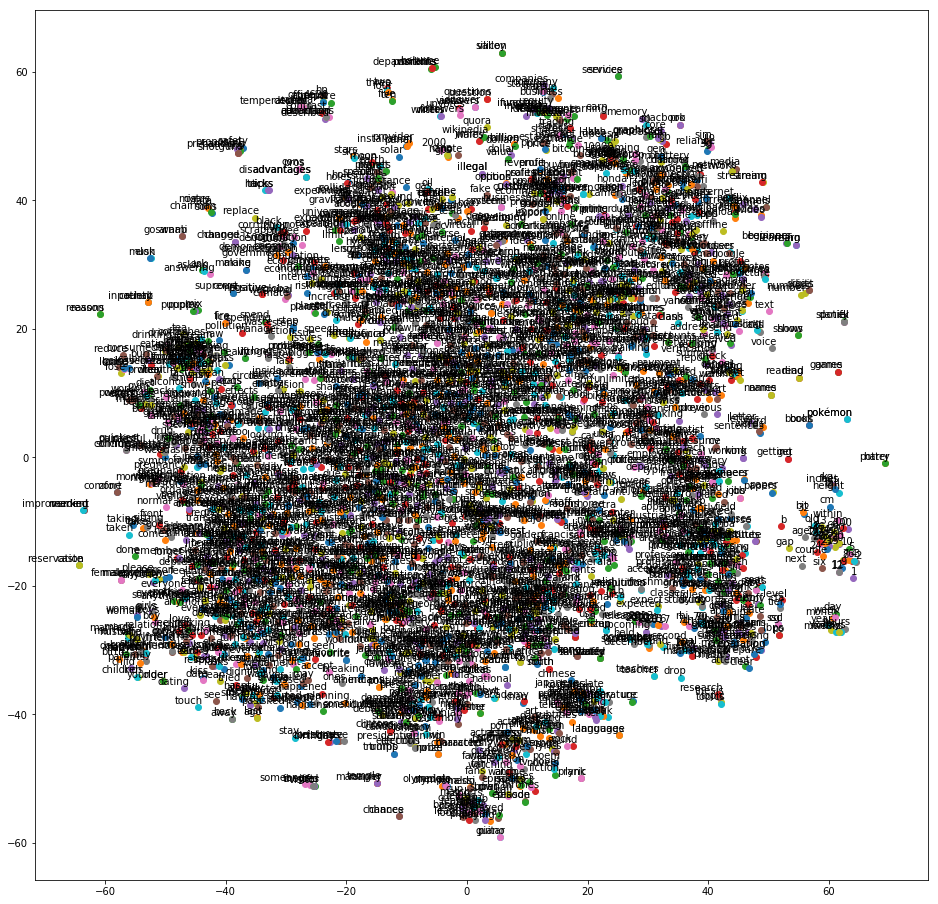

In [11]:
tsne_plot(quora_model)